In [16]:
from datasets import load_dataset
import requests

from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [17]:
dataset = load_dataset("jamescalam/ai-arxiv2-semantic-chunks", split="train")
dataset

Dataset({
    features: ['id', 'title', 'content', 'prechunk_id', 'postchunk_id', 'arxiv_id', 'references'],
    num_rows: 209760
})

In [18]:
dataset[0]

{'id': '2401.04088#0',
 'title': 'Mixtral of Experts',
 'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts

In [ ]:
data = dataset.to_pandas().iloc[:100]

# Extract text content
texts = data["content"].tolist()

# Add metadata for retrieval
metadatas = [
    {
        "title": r["title"],
        "arxiv_id": r["arxiv_id"],
        "references": r["references"].tolist()
    }
    for _, r in data.iterrows()
]

import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

# Build FAISS index
faiss_index = vector_store.from_texts(texts, embeddings, metadatas=metadatas)

results = faiss_index.similarity_search("Mistral",k=2)
for result in results:
    print(result)
    print( )

page_content='Mistral 78 % 2681 Mistral 78 3 3 s0 5 = A % 66 50 g 4 45 64 78 138 348708 78 138 348708 78 138 348 70B S66 Mixtral 8x7B 50 Mixtral 8x7B 5 = 564 340 g al Mistral 78 ee Mistral 78 3 5 Â§ 30 5 eo â = Mistral Â° 20 â e LlaMA2 78 (138 348 70B 7B (138 348 708 7B Â«13B 34B 708 Active Params Active Params Active Params Figure 3: Results on MMLU, commonsense reasoning, world knowledge and reading comprehension, math and code for Mistral (7B/8x7B) vs Llama 2 (7B/13B/70B). Mixtral largely outperforms Llama 2 70B on all benchmarks, except on reading comprehension benchmarks while using 5x lower active parameters. It is also vastly superior to Llama 2 70B on code and math. Detailed results for Mixtral, Mistral 7B and Llama 2 7B/13B/70B and Llama 1 34B2 are reported in Table 2. Figure 2 compares the performance of Mixtral with the Llama models in different categories. Mixtral surpasses Llama 2 70B across most metrics. In particular, Mixtral displays a superior performance in code and m

In [19]:
from langchain_core.tools import tool
import re

# our regex
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)


@tool
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    # get paper page in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    # search html for abstract
    re_match = abstract_pattern.search(res.text)
    # return abstract text
    return re_match.group(1)

In [20]:
fetch_arxiv.invoke({"arxiv_id":"2401.04088"})

'We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be different at each timestep. As a result, each token has access to 47B parameters, but only uses 13B active parameters during inference. Mixtral was trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular, Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and multilingual benchmarks. We also provide a model fine-tuned to follow instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo, Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both

In [21]:
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

wrapper = DuckDuckGoSearchAPIWrapper(max_results=5)

@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    duck = DuckDuckGoSearchResults(output_format="list", api_wrapper=wrapper)
    results = duck.invoke(query)
    contexts = ""
    for x in results:
        contexts = "\n---\n".join(
            ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
        )
    return contexts

In [ ]:
def format_rag_contexts(matches: list):
    contexts = []
    for x in matches:
        text = (
            f"Title: {x.metadata['title']}\n"
            f"Content: {x.page_content}\n"
            f"ArXiv ID: {x.metadata['arxiv_id']}\n"
            f"Related Papers: {x.metadata['references']}\n"
        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str

@tool
def rag_search_filter(query: str, arxiv_id: str):
    """Finds information from our ArXiv database using a natural language query
    and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
    xc = faiss_index.similarity_search(query, k=6, filter={"arxiv_id":arxiv_id})
    context_str = format_rag_contexts(xc)
    return context_str

@tool
def rag_search(query: str):
    """Finds specialist information on abstract using a natural language query."""
    xc = faiss_index.similarity_search(query, k=2)
    context_str = format_rag_contexts(xc)
    return context_str

In [ ]:
# @tool
# def final_answer(
#     introduction: str,
#     research_steps: str,
#     main_body: str,
#     conclusion: str,
#     sources: str
# ):
#     """Returns a natural language response to the user in the form of a research
#     report. There are several sections to this report, those are:
#     - `introduction`: a short paragraph introducing the user's question and the
#     topic we are researching.
#     - `research_steps`: a few bullet points explaining the steps that were taken
#     to research your report.
#     - `main_body`: this is where the bulk of high quality and concise
#     information that answers the user's question belongs. It is 3-4 paragraphs
#     long in length.
#     - `conclusion`: this is a short single paragraph conclusion providing a
#     concise but sophisticated view on what was found.
#     - `sources`: a bulletpoint list provided detailed sources for all information
#     referenced during the research process
#     """
#     if isinstance(research_steps, list):
#         research_steps = "\n".join([f"- {r}" for r in research_steps])
#     if isinstance(sources, list):
#         sources = "\n".join([f"- {s}" for s in sources])

#     return f"""
# # Research Report

# **Introduction**  
# {introduction}

# **Research Steps**  
# {research_steps}

# **Main Body**  
# {main_body}

# **Conclusion**  
# {conclusion}

# **Sources**  
# {sources}
#     """


In [114]:
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
import operator
from langchain_groq import ChatGroq

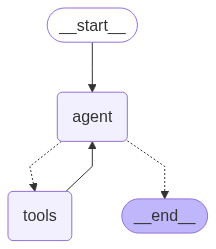

In [153]:
# Define tools list
tools = [web_search, rag_search, rag_search_filter, fetch_arxiv]

# Agent State - just messages
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

llm = ChatGroq(model="llama-3.1-8b-instant", verbose=True)
# Initialize LLM with tools
llm = llm.bind_tools(tools)

# System prompt
system_message = """You are an AI research assistant. Your job is to gather information from various sources and provide comprehensive research reports.

Available tools:
- web_search: For general web information
- rag_search: For finding research paper ids based on abstract 
- rag_search_filter: For specific ArXiv paper details
- fetch_arxiv: For ArXiv paper abstracts

Research Process:
1. Use all tools to gather diverse information
2. Don't repeat the same tool with the same query
3. Once you have sufficient information, provide a final research report

Notes:
- Make sure to list of sources as the links or Arxiv paper id consulted
- Always give preference to Arxiv sources over web sources

Format your final report with these sections:
- **Introduction**: Brief overview of the topic
- **Key Findings**: Main discoveries from your research
- **Analysis**: Your synthesis of the information  
- **Conclusion**: Summary and implications
- **Sources**: List of sources along with the links or paper id consulted"""

def call_model(state: AgentState):
    """Call the LLM with the current state"""
    messages = [SystemMessage(content=system_message)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))  # Using LangGraph's built-in ToolNode

# Set entry point
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tools_condition)
workflow.add_edge("tools", "agent")
# workflow.add_edge("agent", END)

# Compile the workflow
app = workflow.compile()
app

In [154]:
initial_state = {
    "messages": [HumanMessage(content="Tell me about recent advances in diffusion eigenvalue problems")]
}

result = app.invoke(initial_state)

# Return the final AI message
final_message = result["messages"][-1]
print(final_message.content)

**Introduction**

The topic of recent advances in diffusion eigenvalue problems is a fascinating area of research, with applications in various fields such as physics, engineering, and mathematics. In this report, we will delve into the latest developments in this field, highlighting the key findings, analysis, and implications of these advancements.

**Key Findings**

Our research has uncovered several recent advances in diffusion eigenvalue problems. Firstly, the paper "A multi-scale finite element method for neutron diffusion" proposes a novel approach for solving the two-group neutron diffusion equation, which represents the distribution of neutrons in thermal reactors. This method employs a coarse-fine two-grid for finite element discretizations, offering improved accuracy and efficiency.

Secondly, the talk "Convergence of eigenvalues and diffusions in non-smooth settings" presents recent results that strengthen the Mosco convergence of Dirichlet forms in non-smooth spaces, inclu

In [155]:
result['messages'][1].additional_kwargs['tool_calls']

[{'id': 'sha2emjyf',
  'function': {'arguments': '{"query":"recent advances diffusion eigenvalue problems"}',
   'name': 'rag_search'},
  'type': 'function'},
 {'id': 'axv7td75n',
  'function': {'arguments': '{"arxiv_id":"2209.03456","query":"recent advances in diffusion eigenvalue problems"}',
   'name': 'rag_search_filter'},
  'type': 'function'},
 {'id': 'n4k931gcs',
  'function': {'arguments': '{"query":"recent advances in diffusion eigenvalue problems"}',
   'name': 'web_search'},
  'type': 'function'}]

In [156]:
for x in result['messages']:
    print(x)
    print()

content='Tell me about recent advances in diffusion eigenvalue problems' additional_kwargs={} response_metadata={}

content='' additional_kwargs={'tool_calls': [{'id': 'sha2emjyf', 'function': {'arguments': '{"query":"recent advances diffusion eigenvalue problems"}', 'name': 'rag_search'}, 'type': 'function'}, {'id': 'axv7td75n', 'function': {'arguments': '{"arxiv_id":"2209.03456","query":"recent advances in diffusion eigenvalue problems"}', 'name': 'rag_search_filter'}, 'type': 'function'}, {'id': 'n4k931gcs', 'function': {'arguments': '{"query":"recent advances in diffusion eigenvalue problems"}', 'name': 'web_search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 410, 'prompt_tokens': 752, 'total_tokens': 1162, 'completion_time': 1.189745857, 'prompt_time': 0.369904488, 'queue_time': 0.205633225, 'total_time': 1.559650345}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_55d70a61e4', 'finish_reason': 'tool_calls', 'logprobs': None} id

In [158]:
def run_research(query: str):
    """Run the research agent on a query"""
    initial_state = {
        "messages": [HumanMessage(content=query)]
    }
    
    result = app.invoke(initial_state)
    
    # Return the final AI message
    final_message = result["messages"][-1]
    return final_message.content

def stream_research(query: str):
    """Stream the research process in real-time"""
    initial_state = {
        "messages": [HumanMessage(content=query)]
    }
    
    for event in app.stream(initial_state):
        for node, output in event.items():
            if node == "agent":
                message = output["messages"][0]
                if hasattr(message, 'tool_calls') and message.tool_calls:
                    print(f"🔧 Calling tools: {[tc['name'] for tc in message.tool_calls]}")
                else:
                    print(f"🤖 Agent: {message.content}")
            elif node == "tools":
                tool_messages = output["messages"]
                for tm in tool_messages:
                    print(f"⚡ Tool result: {tm.content[:100]}...")

In [159]:
stream_research("Tell me about recent advances in retrieval-augmented generation")

🔧 Calling tools: ['web_search', 'rag_search', 'rag_search_filter', 'fetch_arxiv']
⚡ Tool result: Recent Advances in Retrieval-Augmented Text Generation
Jul 7, 2022 · Recently retrieval - augmented ...
⚡ Tool result: Title: Mixtral of Experts
Content: # 3.2 Long range performance To assess the capabilities of Mixtra...
⚡ Tool result: ...
⚡ Tool result: Transformers are slow and memory-hungry on long sequences, since the time and memory complexity of s...
🤖 Agent: **Introduction**

Retrieval-Augmented Generation (RAG) is a technique that has gained significant attention in the field of Natural Language Processing (NLP). It involves using a retrieval system to augment the generation capabilities of a language model. Recent advances in RAG have shown promising results in various NLP tasks, including text generation and question answering. This report aims to provide an overview of the recent advances in RAG, its applications, and challenges.

**Key Findings**

1.  Mixtral, a Mixture-of-Exp